# Bank Marketing Analysis

## Objective
Optimize the predictive model for term deposit subscriptions using a streamlined workflow:
1. Test default performance.
2. Fine-tune using GridSearchCV/RandomizedSearchCV.
3. Validate using Cross-Validation (Aggregation).
4. Final evaluation on Test Set.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, PrecisionRecallDisplay
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*")

## 1. Data Loading and Preparation

In [ ]:
# Load data
df = pd.read_csv("data/bank-additional-full.csv", sep=';')

# Map target to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})

X = df.drop('y', axis=1)
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (32950, 20)
Testing Shape: (8238, 20)


In [3]:
# Define column groups
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


## 2. Preprocessing Pipelines
We differentiate preprocessing for Linear Models vs Tree-based models.
- **LogReg**: StandardScaler + OneHotEncoder(drop='first')
- **Tree Models**: StandardScaler (optional but kept for consistency) + OneHotEncoder(handle_unknown='ignore')

In [4]:
# Preprocessor for Linear Models
log_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Preprocessor for Tree-based Models
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## 3. Evaluation Helper Function
This function performs cross-validation prediction on the training set to evaluate model performance without touching the test set.

In [5]:
def evaluate_cv(model, X, y, cv=5):
    """
    Performs cross-val predict and returns metrics and report.
    """    
    y_proba = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    auc = roc_auc_score(y, y_proba)

    print("--- Cross-Validation Performance (Aggregated) ---")
    print(classification_report(y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    if auc != "N/A":
        print(f"AUC-ROC: {auc:.4f}")
        
    metrics = {
        'Accuracy': balanced_accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0, average='macro'),
        'Recall': recall_score(y, y_pred, average='macro'),
        'F1': f1_score(y, y_pred, average='macro'),
        'Precision_pos1': precision_score(y, y_pred, pos_label=1, zero_division=0),
        'Recall_pos1': recall_score(y, y_pred, pos_label=1),
        'F1_pos1': f1_score(y, y_pred, pos_label=1),
        'AUC': auc
    }
    return y_pred, y_proba, metrics

## 4. Modeling & Tuning Pipeline

In [6]:
# Store comparison results
model_results = []

### 4.1 Logistic Regression

In [ ]:
print("Training Default Logistic Regression...")
log_clf = Pipeline([
    ('preprocessor', log_preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Default eval
evaluate_cv(log_clf, X_train, y_train)

# Tuning
print("\nTuning Logistic Regression...")
param_grid_log = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__class_weight': [None, 'balanced']
}
grid_log = GridSearchCV(log_clf, param_grid_log, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_log.fit(X_train, y_train)

print(f"Best Params: {grid_log.best_params_}")
best_log_clf = grid_log.best_estimator_

# Best model
y_pred, y_proba, metrics_log = evaluate_cv(best_log_clf, X_train, y_train)
metrics_log['Model'] = 'Logistic Regression'
model_results.append(metrics_log)

Training Default Logistic Regression...
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     29238
           1       0.66      0.42      0.51      3712

    accuracy                           0.91     32950
   macro avg       0.79      0.69      0.73     32950
weighted avg       0.90      0.91      0.90     32950

Confusion Matrix:
 [[28431   807]
 [ 2170  1542]]
AUC-ROC: 0.9331

Tuning Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__solver': 'liblinear'}
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     29238
           1       0.44      0.88      0.58      3712

    accuracy                           0.86     32950
   macro avg       0.71      0.87      0.75    

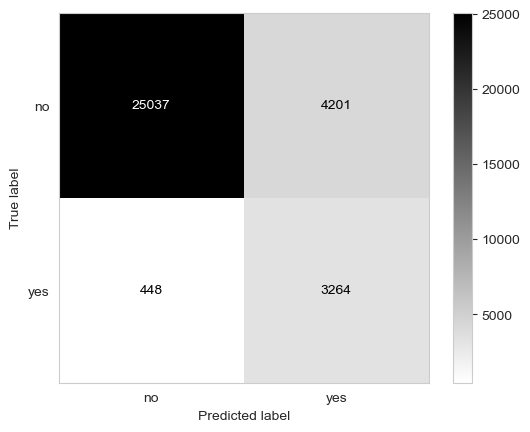

In [8]:
disp = ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

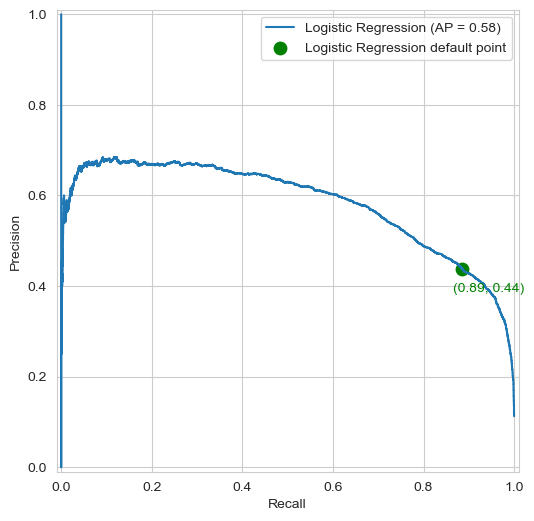

In [11]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, PrecisionRecallDisplay

# PR curve points (this is for label = 1; if checking label = 0, use predict_proba[:,0] & pos_label=0)
precision, recall, thresholds = precision_recall_curve(y_train, best_log_clf.predict_proba(X_train)[:,1])

# default point's prec and rec
prec, rec, f1, _ = precision_recall_fscore_support(y_train, best_log_clf.predict(X_train), average="binary")

fig, ax = plt.subplots(figsize=(8, 6))
disp2 = PrecisionRecallDisplay.from_estimator(best_log_clf, X_train, y_train, ax=ax, name="Logistic Regression")

ax.scatter(rec, prec, color="green", s=80, label="Logistic Regression default point")
ax.text(rec - 0.02, prec - 0.05, f"({rec:.2f}, {prec:.2f})", color="green")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


In [23]:
# define a function to search the best threshold
def search_best_threshold(precision, recall, thresholds):
    f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
    best_idx = np.argmax(f1)
    best_threshold = thresholds[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    return best_threshold, f1


0.7604860850769457


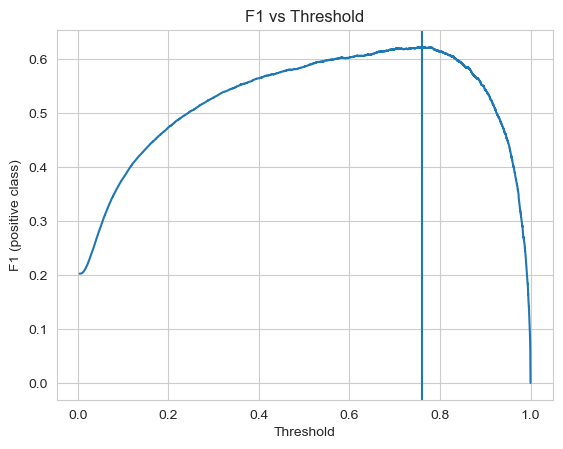

In [13]:
best_t, f1 = search_best_threshold(precision, recall, thresholds)  
print(best_t)

plt.plot(thresholds, f1)
plt.axvline(best_t)
plt.xlabel("Threshold")
plt.ylabel("F1 (positive class)")
plt.title("F1 vs Threshold")
plt.show()

0.7604860850769457


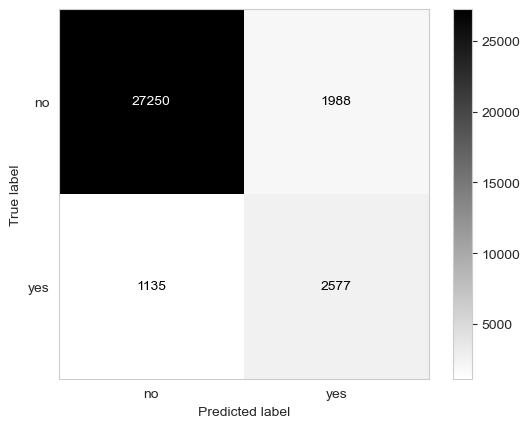

In [15]:
# Post-adjustment Confusion Matrix (only use predict_proba because cross_eval's predict is a concatenated array of five cv models, not realistic)
print(best_t)

post_disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_log_clf.predict_proba(X_train)[:,1]>=best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
# post_disp = ConfusionMatrixDisplay.from_predictions(y_train, (y_proba>=best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')

post_disp.ax_.grid(False)

In [16]:
grid_log.best_params_

{'classifier__C': 10,
 'classifier__class_weight': 'balanced',
 'classifier__solver': 'liblinear'}

### 4.2 Decision Tree

In [17]:
print("Training Default Decision Tree...")
dt_clf = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Default Eval
evaluate_cv(dt_clf, X_train, y_train)

# Tuning
print("\nTuning Decision Tree...")
param_grid_dt = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 10, 50],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__class_weight': ['balanced', None]
}
grid_dt = GridSearchCV(dt_clf, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print(f"Best Params: {grid_dt.best_params_}")
best_dt_clf = grid_dt.best_estimator_

# Best model
y_pred, y_proba, metrics_dt = evaluate_cv(best_dt_clf, X_train, y_train)
metrics_dt['Model'] = 'Decision Tree'
model_results.append(metrics_dt)

Training Default Decision Tree...
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     29238
           1       0.49      0.50      0.50      3712

    accuracy                           0.89     32950
   macro avg       0.72      0.72      0.72     32950
weighted avg       0.89      0.89      0.89     32950

Confusion Matrix:
 [[27326  1912]
 [ 1849  1863]]
AUC-ROC: 0.7182

Tuning Decision Tree...
Best Params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     29238
           1       0.45      0.85      0.59      3712

    accuracy                           0.87     32950
   macro avg       0.71      0.86      0.75     32950
weighted avg       0.

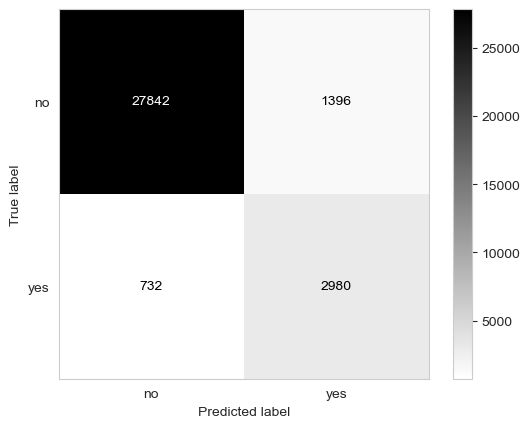

In [18]:
# search the best threshold
precision, recall, thresholds = precision_recall_curve(y_train, best_dt_clf.predict_proba(X_train)[:,1])

best_t, f1 = search_best_threshold(precision, recall, thresholds)  

disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_dt_clf.predict_proba(X_train)[:,1] > best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

### 4.3 Random Forest

In [19]:
print("Training Default Random Forest...")
rf_clf = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Default Eval
evaluate_cv(rf_clf, X_train, y_train)

# Tuning
print("\nTuning Random Forest...")
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__class_weight': ['balanced', None]
}
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Best Params: {grid_rf.best_params_}")
best_rf_clf = grid_rf.best_estimator_

# Best Model Eval
y_pred, y_proba, metrics_rf = evaluate_cv(best_rf_clf, X_train, y_train)
metrics_rf['Model'] = 'Random Forest'
model_results.append(metrics_rf)

Training Default Random Forest...
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     29238
           1       0.65      0.45      0.53      3712

    accuracy                           0.91     32950
   macro avg       0.79      0.71      0.74     32950
weighted avg       0.90      0.91      0.90     32950

Confusion Matrix:
 [[28336   902]
 [ 2032  1680]]
AUC-ROC: 0.9373

Tuning Random Forest...
Best Params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 200}
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.98      0.90      0.93     29238
           1       0.50      0.84      0.63      3712

    accuracy                           0.89     32950
   macro avg       0.74      0.87      0.78     32950
weighted avg       0.92

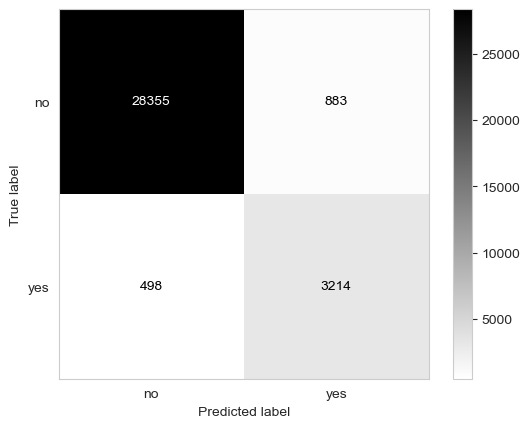

In [20]:
# search the best threshold
precision, recall, thresholds = precision_recall_curve(y_train, best_rf_clf.predict_proba(X_train)[:,1])

best_t, f1 = search_best_threshold(precision, recall, thresholds)  

disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_rf_clf.predict_proba(X_train)[:,1] > best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

### 4.4 XGBoost

In [21]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
scale_pos_weight

7.876616379310345

In [22]:
print("Training Default XGBoost...")
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_clf = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=42))
])

# Default Eval
evaluate_cv(xgb_clf, X_train, y_train)

# Tuning - Using RandomizedSearchCV for efficiency
print("\nTuning XGBoost...")
param_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [scale_pos_weight, None]
}
rand_xgb = GridSearchCV(xgb_clf, param_grid=param_xgb, cv=5, scoring='f1', n_jobs=-1)
rand_xgb.fit(X_train, y_train)

print(f"Best Params: {rand_xgb.best_params_}")
best_xgb_clf = rand_xgb.best_estimator_

# Best Model Eval
y_pred, y_proba, metrics_xgb = evaluate_cv(best_xgb_clf, X_train, y_train)
metrics_xgb['Model'] = 'XGBoost'
model_results.append(metrics_xgb)

Training Default XGBoost...
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     29238
           1       0.63      0.54      0.58      3712

    accuracy                           0.91     32950
   macro avg       0.79      0.75      0.77     32950
weighted avg       0.91      0.91      0.91     32950

Confusion Matrix:
 [[28064  1174]
 [ 1696  2016]]
AUC-ROC: 0.9438

Tuning XGBoost...
Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 7.876616379310345, 'classifier__subsample': 0.8}
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     29238
           1       0.51      0.82      0.63      3712

    accuracy                           0.89     32950
   macro avg   

Best threshold: 0.7807782888412476


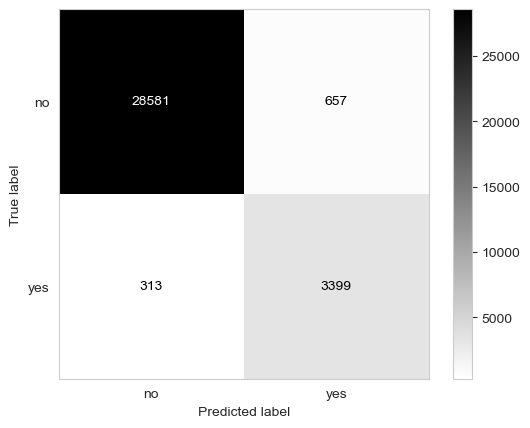

In [23]:
# search the best threshold
precision, recall, thresholds = precision_recall_curve(y_train, best_xgb_clf.predict_proba(X_train)[:,1])

best_t, f1 = search_best_threshold(precision, recall, thresholds)  

print(f"Best threshold: {best_t}")
disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_xgb_clf.predict_proba(X_train)[:,1] > best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

### 4.5 LightGBM

In [24]:
print("Training Default LightGBM...")
lgbm_clf = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, importances_type='gain'))
])

# Default Eval
evaluate_cv(lgbm_clf, X_train, y_train)

# Tuning - using RandomizedSearchCV
print("\nTuning LightGBM...")
param_dist_lgbm = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50, 100],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__class_weight': ['balanced', None]
}
rand_lgbm = RandomizedSearchCV(lgbm_clf, param_distributions=param_dist_lgbm, n_iter=40, cv=5, scoring='f1', n_jobs=-1, random_state=42)
rand_lgbm.fit(X_train, y_train)

print(f"Best Params: {rand_lgbm.best_params_}")
best_lgbm_clf = rand_lgbm.best_estimator_

# Best Model Eval
y_pred, y_proba,metrics_lgbm = evaluate_cv(best_lgbm_clf, X_train, y_train)
metrics_lgbm['Model'] = 'LightGBM'
model_results.append(metrics_lgbm)

Training Default LightGBM...


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     29238
           1       0.65      0.54      0.59      3712

    accuracy                           0.92     32950
   macro avg       0.80      0.75      0.77     32950
weighted avg       0.91      0.92      0.91     32950

Confusion Matrix:
 [[28165  1073]
 [ 1717  1995]]
AUC-ROC: 0.9482

Tuning LightGBM...


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

Best Params: {'classifier__subsample': 1.0, 'classifier__num_leaves': 50, 'classifier__n_estimators': 500, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8, 'classifier__class_weight': 'balanced'}


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     29238
           1       0.51      0.83      0.63      3712

    accuracy                           0.89     32950
   macro avg       0.74      0.87      0.78     32950
weighted avg       0.92      0.89      0.90     32950

Confusion Matrix:
 [[26244  2994]
 [  617  3095]]
AUC-ROC: 0.9442


/opt/anaconda3/envs/dslearn/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


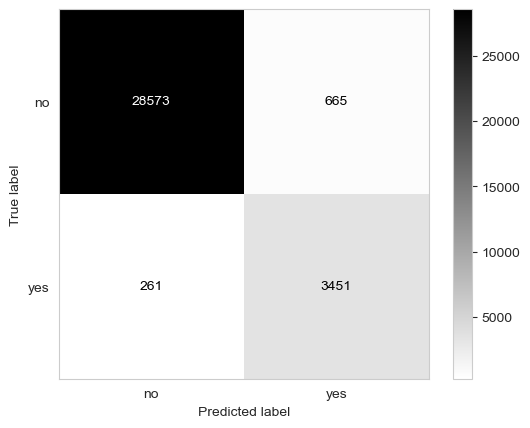

In [18]:
# search the best threshold
precision, recall, thresholds = precision_recall_curve(y_train, best_lgbm_clf.predict_proba(X_train)[:,1])

best_t, f1 = search_best_threshold(precision, recall, thresholds)

disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_lgbm_clf.predict_proba(X_train)[:,1] > best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

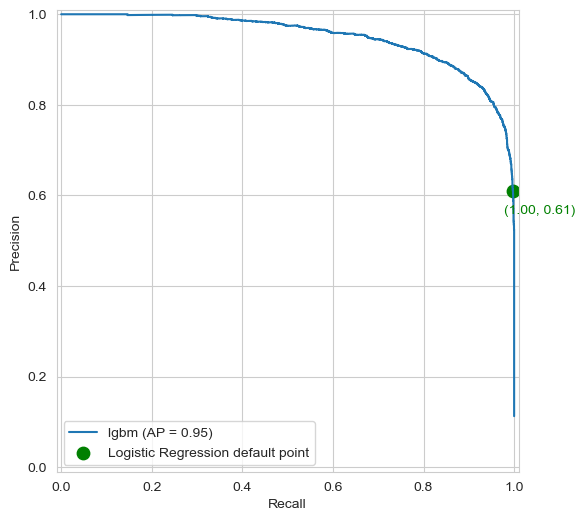

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

disp2 = PrecisionRecallDisplay.from_estimator(best_lgbm_clf, X_train, y_train, ax=ax, name="lgbm")
prec, rec, f1_scores, _ = precision_recall_fscore_support(y_train, best_lgbm_clf.predict(X_train), average="binary")

ax.scatter(rec, prec, color="green", s=80, label="Logistic Regression default point")
ax.text(rec - 0.02, prec - 0.05, f"({rec:.2f}, {prec:.2f})", color="green")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()

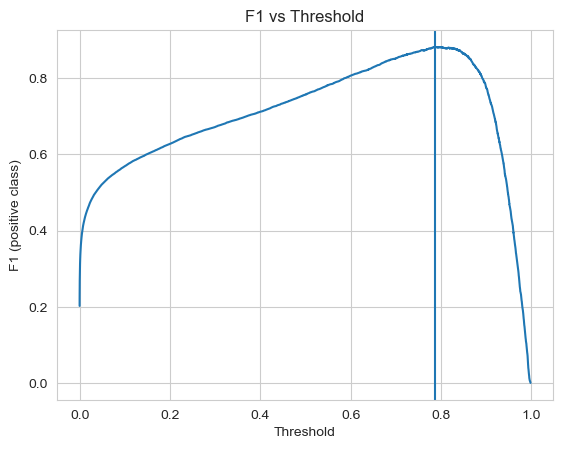

In [27]:
plt.plot(thresholds, f1)
plt.axvline(best_t)
plt.xlabel("Threshold")
plt.ylabel("F1 (positive class)")
plt.title("F1 vs Threshold")
plt.show()

### 4.6 SVC

In [29]:
print("Training Default SVC...")
svc_clf = Pipeline([
    ('preprocessor', log_preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Default Eval
evaluate_cv(svc_clf, X_train, y_train)

# Tuning - using RandomizedSearchCV
print("\nTuning SVC...")
param_dist_svc = [
    {
        'classifier__kernel': ['linear'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__class_weight': ['balanced', None]
    },
    {
        'classifier__kernel': ['poly'],
        'classifier__C': [0.1, 100],
        'classifier__degree': [2],
        'classifier__gamma': ['scale', 0.01, 0.1, 1],
        'classifier__class_weight': ['balanced', None]
    }
]
# Take out rbf kernel for now, time constraint
    # {
    #     'classifier__kernel': ['rbf'],
    #     'classifier__C': [0.1, 100],
    #     'classifier__gamma': ['scale', 0.01, 0.1, 1],
    #     'classifier__class_weight': ['balanced', None]
    # }

rand_svc = RandomizedSearchCV(svc_clf, param_distributions=param_dist_svc, n_iter=10, cv=5, scoring='f1', n_jobs=-1, verbose = 2, random_state=42)
rand_svc.fit(X_train, y_train)

print(f"Best Params: {rand_svc.best_params_}")
best_svc_clf = rand_svc.best_estimator_

# Best Model Eval
y_pred, y_proba, metrics_svc = evaluate_cv(best_svc_clf, X_train, y_train)
metrics_svc['Model'] = 'SVC'
model_results.append(metrics_svc)

Training Default SVC...
--- Cross-Validation Performance (Aggregated) ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     29238
           1       0.67      0.38      0.48      3712

    accuracy                           0.91     32950
   macro avg       0.80      0.68      0.72     32950
weighted avg       0.90      0.91      0.90     32950

Confusion Matrix:
 [[28532   706]
 [ 2310  1402]]
AUC-ROC: 0.9009

Tuning SVC...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__degree=2, classifier__gamma=scale, classifier__kernel=poly; total time= 5.7min
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__degree=2, classifier__gamma=scale, classifier__kernel=poly; total time= 5.8min
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__degree=2, classifier__gamma=scale, classifier__kernel=poly; total time= 5.

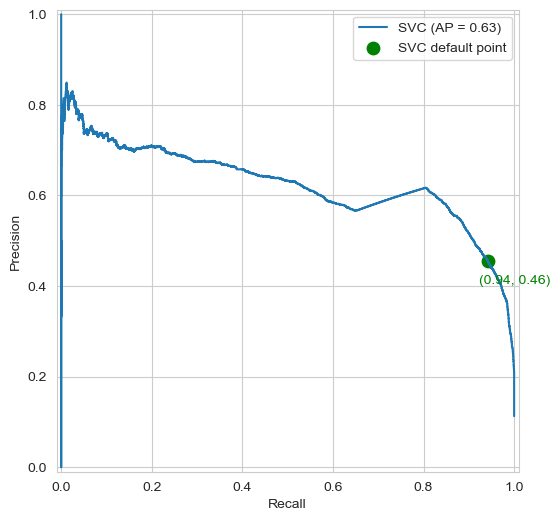

In [30]:
precision, recall, thresholds = precision_recall_curve(y_train, best_svc_clf.predict_proba(X_train)[:,1])

prec, rec, f1, _ = precision_recall_fscore_support(y_train, best_svc_clf.predict(X_train), average="binary")

fig, ax = plt.subplots(figsize=(8, 6))
disp2 = PrecisionRecallDisplay.from_estimator(best_svc_clf, X_train, y_train, ax=ax, name="SVC")

ax.scatter(rec, prec, color="green", s=80, label="SVC default point")
ax.text(rec - 0.02, prec - 0.05, f"({rec:.2f}, {prec:.2f})", color="green")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


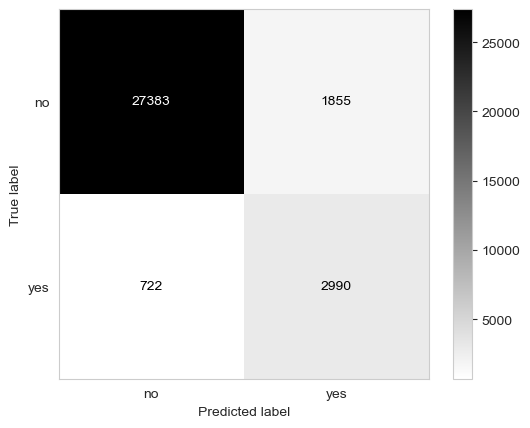

In [17]:
# search the best threshold
precision, recall, thresholds = precision_recall_curve(y_train, best_svc_clf.predict_proba(X_train)[:,1])

best_t, f1 = search_best_threshold(precision, recall, thresholds)  

disp = ConfusionMatrixDisplay.from_predictions(y_train, (best_svc_clf.predict_proba(X_train)[:,1] >= best_t).astype(int), display_labels = ['no', 'yes'], cmap = 'gray_r')
disp.ax_.grid(False)

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, ts = metrics.roc_curve(y_train, y_proba)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  name='example estimator')
display.plot()
plt.show()

## 5. Model Comparison

                     Accuracy  Precision    Recall        F1  Precision_pos1  \
Model                                                                          
LightGBM             0.865691   0.742662  0.865691  0.783600        0.508294   
Random Forest        0.867677   0.741295  0.867677  0.782690        0.504776   
XGBoost              0.860132   0.742093  0.860132  0.782042        0.508851   
Decision Tree        0.857186   0.714126  0.857186  0.753943        0.450344   
Logistic Regression  0.867814   0.709831  0.867814  0.749551        0.437240   
SVC                  0.674245   0.774114  0.674245  0.708772        0.623498   

                     Recall_pos1   F1_pos1       AUC  
Model                                                 
LightGBM                0.833782  0.631568  0.944197  
Random Forest           0.839978  0.630600  0.943807  
XGBoost                 0.820851  0.628247  0.943266  
Decision Tree           0.845366  0.587640  0.897371  
Logistic Regression     0.879

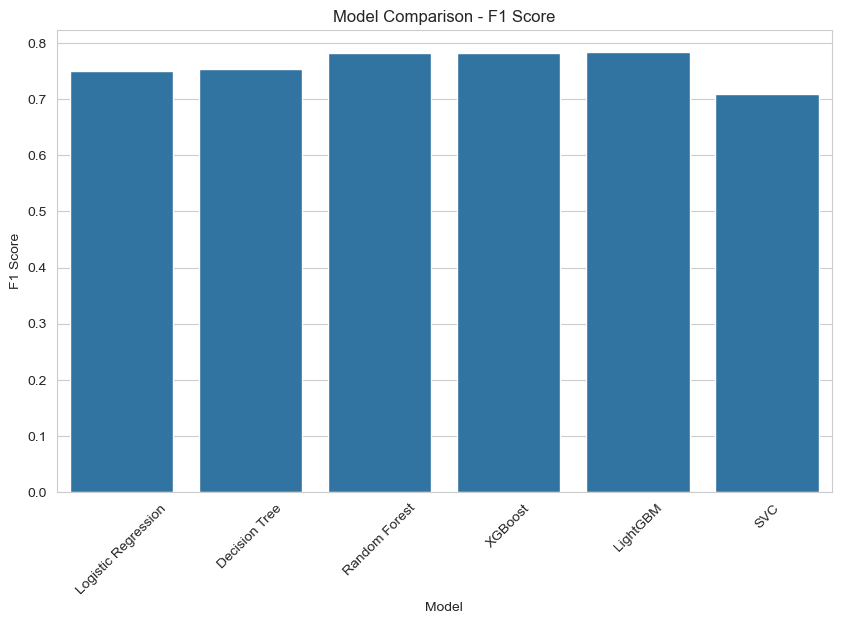

In [32]:
comparison_df = pd.DataFrame(model_results).set_index('Model')
print(comparison_df.sort_values(by='F1', ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(x=comparison_df.index, y=comparison_df['F1'])
plt.title('Model Comparison - F1 Score')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

## 6. Final Evaluation on Test Set
We select the model with the best cross-validation F1 score (or Recall depending on business case) for the final test set evaluation.

In [ ]:
best_model_name = comparison_df['F1'].idxmax()
print(f"Best Model Selected: {best_model_name}")

# Retrieve the best model object
if best_model_name == 'Logistic Regression':
    final_model = best_log_clf
elif best_model_name == 'Decision Tree':
    final_model = best_dt_clf
elif best_model_name == 'Random Forest':
    final_model = best_rf_clf
elif best_model_name == 'XGBoost':
    final_model = best_xgb_clf
elif best_model_name == 'LightGBM':
    final_model = best_lgbm_clf
elif best_model_name == 'SVC':
    final_model = best_svc_clf

# Predict on Test Set
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

print("--- Final Test Set Evaluation ---")
print(classification_report(y_test, (y_test_proba>=best_t).astype(int)))
print("Confusion Matrix:\n", confusion_matrix(y_test, (y_test_proba>=best_t).astype(int)))
print(f"Accuracy: {accuracy_score(y_test, (y_test_proba>=best_t).astype(int)):.4f}")

Best Model Selected: LightGBM
--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7310
           1       0.62      0.66      0.64       928

    accuracy                           0.92      8238
   macro avg       0.79      0.80      0.80      8238
weighted avg       0.92      0.92      0.92      8238

Confusion Matrix:
 [[6941  369]
 [ 316  612]]
Accuracy: 0.9168


In [36]:
# Adjust the threshold for lead classification: from 0.5 to best_t
best_t

np.float64(0.7876649123638625)

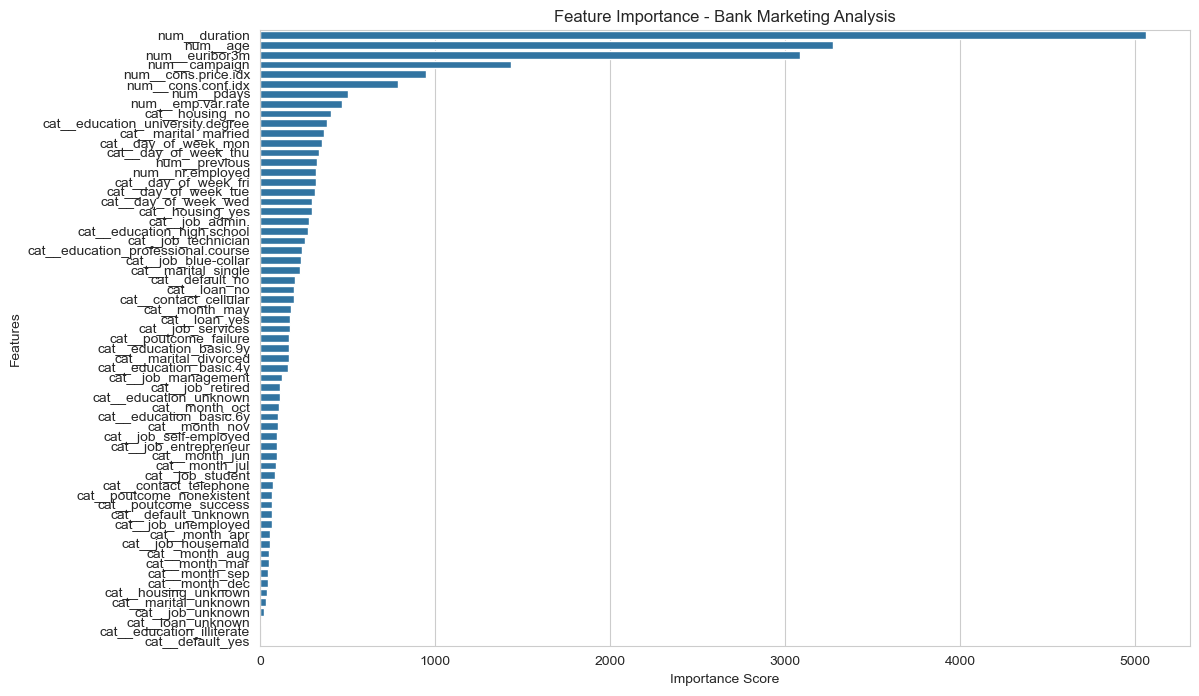

array([3273, 5061, 1435,  504,  329,  471,  950,  790, 3088,  318,  280,
        234,   96,   58,  127,  116,   99,  170,   89,  259,   69,   22,
        166,  369,  230,   33,  158,  105,  167,  277,    0,  239,  384,
        114,  203,   70,    0,  404,   43,  296,  196,    8,  172,  195,
         73,   59,   53,   44,   91,   95,   52,  180,  102,  107,   46,
        318,  354,  335,  316,  298,  169,   71,   70], dtype=int32)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature names from the preprocessor and importances from the classifier
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importances = final_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Bank Marketing Analysis')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Interpretation:
# The plot identifies the most influential variables in predicting the target outcome. 
# Features at the top (e.g., duration, social/economic indicators) have the highest predictive power, 
# suggesting they are the primary drivers for the model's classification decisions.

final_model.named_steps['classifier'].feature_importances_

In [39]:
import shap

X_transformed = final_model.named_steps['preprocessor'].transform(X_test)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

explainer = shap.TreeExplainer(final_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_transformed)
shap_values

array([[ 1.40702181e-01, -1.57721072e+00, -4.63632525e-01, ...,
         3.14758065e-02, -4.23734752e-05, -5.25616159e-03],
       [ 5.32953075e-02, -1.61402484e+00,  6.71569603e-01, ...,
         5.00640425e-02, -2.96735519e-04, -3.28133612e-02],
       [-2.63447230e-01, -9.10846433e-01,  2.43930834e-01, ...,
         8.20020397e-02,  1.71316736e-02, -3.24418144e-02],
       ...,
       [-5.26313607e-02,  3.60970955e+00,  1.29368633e-01, ...,
        -2.33184190e-01,  3.52065542e-03, -2.65877841e-02],
       [ 1.20521162e-01,  6.83662207e+00, -8.61358176e-01, ...,
         2.59807006e-02, -1.46061175e-03, -6.27731972e-03],
       [-1.89315344e-01, -2.59605931e+00, -9.89724806e-01, ...,
         3.55426743e-02,  6.99274567e-03, -7.54038352e-03]])

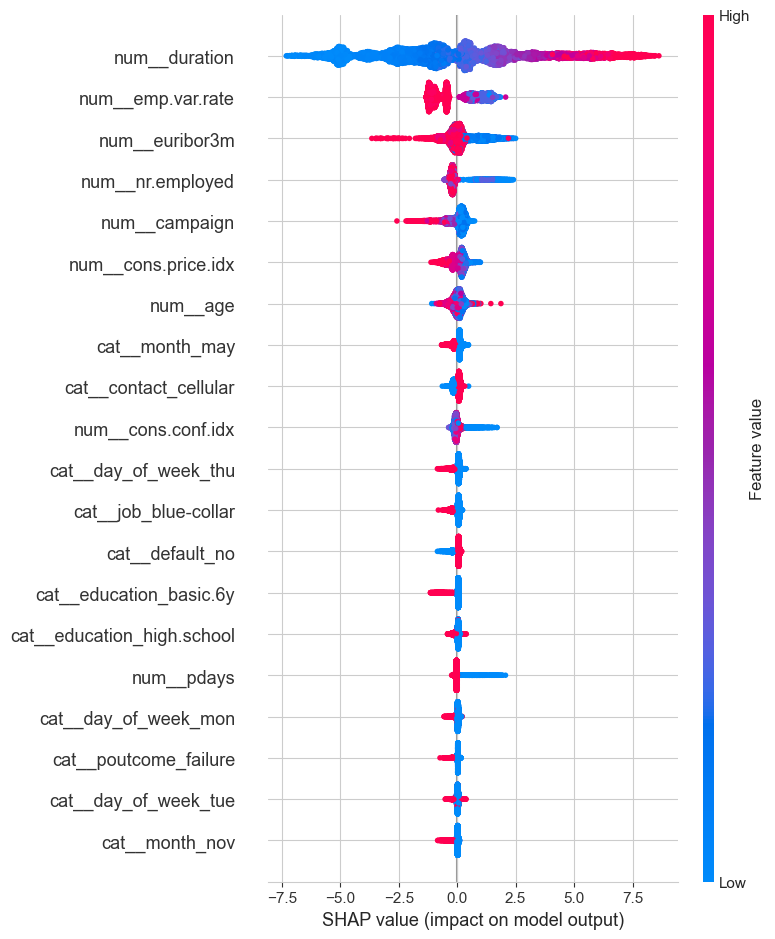

In [40]:
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# summary plot
shap.summary_plot(shap_values_to_plot, X_transformed, feature_names=feature_names)

In [4]:
X_df = pd.DataFrame(X_transformed, columns=feature_names)

explanation = explainer(X_df)

if len(explanation.shape) == 3:
    explanation = explanation[:, :, 1]

# single row's shap contribution
shap.plots.waterfall(explanation[0])

NameError: name 'X_transformed' is not defined

In [ ]:
# shap.initjs()
# shap.plots.force(explanation[0:1000])
# shap.plots.heatmap(explanation[0:1000])

### 📊 Model Interpretability via SHAP

Based on the SHAP Beeswarm plot generated above for our **LightGBM** model, we can derive the following key business insights regarding term deposit subscriptions:

#### 1. The "Long-Tail" Conversion Power of Call Duration
* **Observation**: We see a dense cluster of blue dots (short calls) near the zero SHAP value and a sparse, extended "long-tail" of red dots (long calls) stretching far to the right.
* **Insight**: Call duration is the strongest predictor of success. While short calls are the norm and provide a neutral signal, deep engagement (longer duration) acts as a powerful "tipping point" for conversion.
* **Technical Note**: Since `duration` is a *post-event* feature (only known after the call), it reflects high customer interest rather than pre-call intent.

#### 2. Systemic Headwinds from Macroeconomic Indicators
* **Observation**: Macro indicators like emp.var.rate (employment variation rate) and euribor3m (3-month interest rate) show dense clusters of red dots on the negative (left) side of the SHAP axis.
* **Insight**: High interest rates and high employment variation act as systemic headwinds. During these periods, customer appetite for term deposits drops regardless of individual profiles. Marketing efficiency is likely to be lower during these "expensive" economic cycles.

#### 3. The "Ice-Breaking" Effect of Recent Contact (`pdays`)
* **Observation**: A massive wall of red dots (e.g., $pdays=999$, never contacted) sits slightly left of zero, while a few blue dots (small values, recently contacted) are pushed to the far right.
* **Insight**: Recent engagement is a high-value signal. Customers who were contacted in the recent past are significantly more likely to subscribe. This highlights the effectiveness of lead nurturing; a "warmed-up" lead is far more valuable than a generic prospect.

#### 4. Non-Linear Patterns in Demographics (Overlapping Zones)
* **Observation**: Features like `age` show overlapping red and blue dots on both sides of the zero axis.
* **Insight**: The relationship between age and subscription is non-linear. Both younger (blue) and older (red) segments show high propensity, while the middle-aged "cluster" is more resistant. This suggests that marketing strategies should be based on **Life-Stage Personas** rather than simple linear age brackets.

---

**Strategic Recommendation**: To optimize the marketing funnel, the bank could implement a Tiered Lead Scoring System. High-priority should be given to leads with recent contact history (pdays), while sales teams should be incentivized to move past the "initial resistance" phase of a call, as conversion probability scales with engagement depth (duration)

In [43]:
# 1. Get the probabilities for the positive class (subscription)
y_proba = best_lgbm_clf.predict_proba(X_test)[:, 1]

# 2. Convert probabilities to a 0-100 scale
test_results = pd.DataFrame({
    'Actual': y_test,
    'Probability': y_proba,
    'Lead_Score': (y_proba * 100).astype(int)
})

# 3. Categorize Leads into Tiers
def categorize_lead(score):
    if score > 70: return '1. Hot Lead'
    if score > 30: return '2. Warm Lead'
    return '3. Cold Lead'

test_results['Lead_Tier'] = test_results['Lead_Score'].apply(categorize_lead)

# 4. Analyze the Conversion Rate per Tier
conversion_analysis = test_results.groupby('Lead_Tier').agg({
    'Actual': ['count', 'sum', 'mean']
})
conversion_analysis.columns = ['Total Leads', 'Actual Conversions', 'Conversion Rate']
print(conversion_analysis)

              Total Leads  Actual Conversions  Conversion Rate
Lead_Tier                                                     
1. Hot Lead          1194                 706         0.591290
2. Warm Lead          680                 153         0.225000
3. Cold Lead         6364                  69         0.010842


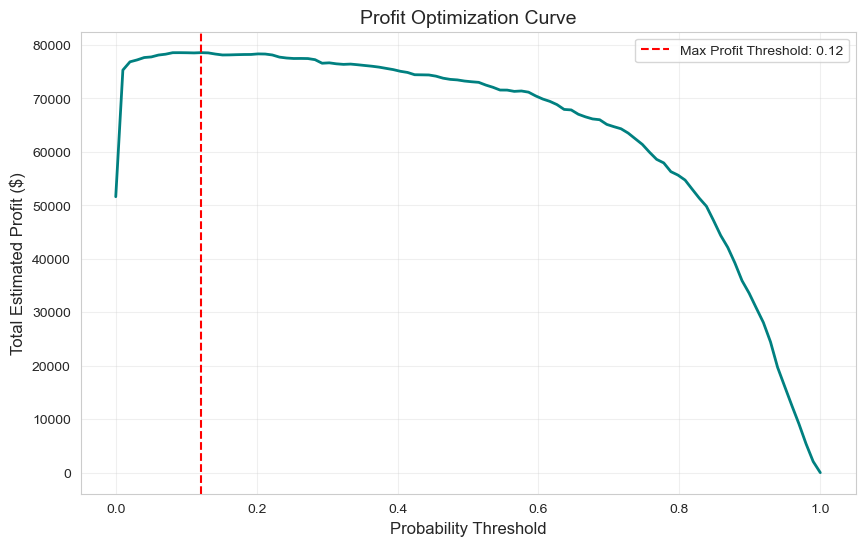

Optimal Threshold for Business: 0.12
Estimated Max Profit: $78,560.00


In [44]:
# Profit optimization for bank marketing
# --- Business Assumptions ---
cost_per_call = 5     # The cost of staff time for one phone call
revenue_per_sub = 100 # The profit the bank makes if a customer subscribes

thresholds = np.linspace(0, 1, 100)
profits = []

for t in thresholds:
    # Predict 1 if probability > threshold
    preds = (y_proba >= t).astype(int)
    
    # Calculate Profit:
    # (True Positives * Revenue) - (Total Calls * Cost)
    tp = ((preds == 1) & (y_test == 1)).sum()
    total_calls = (preds == 1).sum()
    
    current_profit = (tp * revenue_per_sub) - (total_calls * cost_per_call)
    profits.append(current_profit)

# Find the best threshold
best_threshold = thresholds[np.argmax(profits)]
max_profit = max(profits)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, color='teal', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Max Profit Threshold: {best_threshold:.2f}')
plt.title('Profit Optimization Curve', fontsize=14)
plt.xlabel('Probability Threshold', fontsize=12)
plt.ylabel('Total Estimated Profit ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal Threshold for Business: {best_threshold:.2f}")
print(f"Estimated Max Profit: ${max_profit:,.2f}")

## 7. Save the final model to a file

In [ ]:
import os
import joblib

# Create the model directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# List of models to save
models_to_save = [
    ('logistic_regression', best_log_clf),
    ('decision_tree', best_dt_clf),
    ('random_forest', best_rf_clf),
    ('xgboost', best_xgb_clf),
    ('lightgbm', best_lgbm_clf),
    ('svc', best_svc_clf)
]

for model_name, model in models_to_save:
    model_path = os.path.join('model', f'{model_name}_model.joblib')
    joblib.dump(model, model_path)
    print(f"Successfully saved {model_name} to {model_path}")



Successfully saved logistic_regression to model/logistic_regression_model.joblib
Successfully saved decision_tree to model/decision_tree_model.joblib
Successfully saved random_forest to model/random_forest_model.joblib
Successfully saved xgboost to model/xgboost_model.joblib
Successfully saved lightgbm to model/lightgbm_model.joblib
Successfully saved svc to model/svc_model.joblib


In [ ]:
# model = joblib.load('model/svc_model.joblib')
# predictions = model.predict(X_test)

In [6]:
# load back models
import joblib
import os
best_log_clf = joblib.load(os.path.join('model', 'logistic_regression_model.joblib'))
best_dt_clf = joblib.load(os.path.join('model', 'decision_tree_model.joblib'))
best_rf_clf = joblib.load(os.path.join('model', 'random_forest_model.joblib'))
best_xgb_clf = joblib.load(os.path.join('model', 'xgboost_model.joblib'))
best_lgbm_clf = joblib.load(os.path.join('model', 'lightgbm_model.joblib'))
best_svc_clf = joblib.load(os.path.join('model', 'svc_model.joblib'))

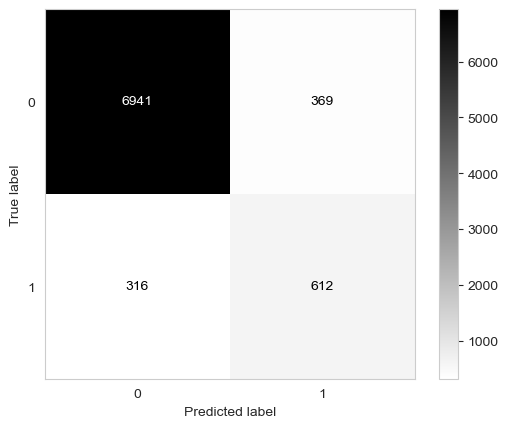

In [20]:
fin_disp = ConfusionMatrixDisplay.from_predictions(y_test, best_lgbm_clf.predict_proba(X_test)[:, 1] > best_t, cmap = 'gray_r')
fin_disp.ax_.grid(False)

## 8. Bonus running a Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

dl_preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])  

X_train_transformed = dl_preprocessor.fit_transform(X_train)
X_test_transformed = dl_preprocessor.transform(X_test)

# Define the sequential model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                tf.keras.metrics.AUC(name="roc_auc"),
                tf.keras.metrics.AUC(name="pr_auc", curve="PR")
                ]
)

# Early stopping
early_stop = EarlyStopping(
    monitor="val_pr_auc",
    mode="max",
    patience=5,
    restore_best_weights=True
)


classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
class_weight

{0: 0.5634790341336616, 1: 4.438308189655173}

In [36]:
history = model.fit(
    X_train_transformed, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    # class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1837 - pr_auc: 0.6136 - roc_auc: 0.9421 - val_loss: 0.1938 - val_pr_auc: 0.6406 - val_roc_auc: 0.9355
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.1720 - pr_auc: 0.6466 - roc_auc: 0.9485 - val_loss: 0.1919 - val_pr_auc: 0.6437 - val_roc_auc: 0.9359
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1706 - pr_auc: 0.6578 - roc_auc: 0.9497 - val_loss: 0.1932 - val_pr_auc: 0.6444 - val_roc_auc: 0.9348
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.1682 - pr_auc: 0.6563 - roc_auc: 0.9506 - val_loss: 0.1939 - val_pr_auc: 0.6456 - val_roc_auc: 0.9349
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.1685 - pr_auc: 0.6530 - roc_auc: 0.9506 - val_loss: 0.1927 - val_pr_auc: 0.6443 - val_roc_auc: 0.9359


In [41]:
y_proba_nn = model.predict(X_test_transformed).ravel()

# PR curve points (this is for label = 1; if checking label = 0, use predict_proba[:,0] & pos_label=0)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_nn)

# Search for the best threshold (optimized for f1)
best_t, f1 = search_best_threshold(precision, recall, thresholds)
print(best_t)

y_pred_nn = (y_proba_nn >= best_t).astype(int)


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
0.36655372


In [ ]:
confusion_matrix(y_test, y_pred_nn)
# Still not much of an improvement, and interpretation is not as clear as for the lxgm.


array([[6738,  572],
       [ 205,  723]])